In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

In [117]:
def RBF(x1,x2,*,length_scale=1.0):
    return np.exp(-0.5/length_scale**2 * (x1-x2)**2)

def dRBF(x1,x2,*,length_scale=1.0):
    return -(x1-x2)/length_scale**2 * RBF(x1,x2,length_scale=length_scale)

def covMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = RBF(xs,ys,length_scale=length_scale)
    
    return mat

def dcovMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = dRBF(xs,ys,length_scale=length_scale)
    
    return mat

def sigmaMatrix(sigma_sq,*,size=0):
    if np.isscalar(sigma_sq):
        return np.eye(size) / sigma_sq
    
    return np.diag(1 / sigma_sq)

In [118]:
def func(x,noise=0.0):
    return np.sin(x) + noise*np.random.randn(*x.shape)

def grad_func(x,noise=0.0):
    return np.cos(x) + noise*np.random.randn(*x.shape)

## Sparse GPR

In [119]:
bounds = np.array([0.0, np.pi])

noise = 0.1

length_scale = 1.0

num_reference_points = 10
referencegrid = np.linspace(*bounds,num_reference_points)

num_datapoints = 15
datagrid = np.random.uniform(*bounds,num_datapoints)
data_values = func(datagrid,noise)
derivative_values = grad_func(datagrid,noise)

num_gridpoints = 101
grid = np.linspace(*bounds,num_gridpoints)

In [120]:
K_MM = covMatrix(reference_points=referencegrid,data_points=referencegrid,length_scale=length_scale)
K_MN = covMatrix(reference_points=referencegrid,data_points=datagrid,length_scale=length_scale)
DK_MN = dcovMatrix(reference_points=referencegrid,data_points=datagrid,length_scale=length_scale)
LK = np.concatenate((K_MN,DK_MN),axis=1)

S_big = sigmaMatrix(noise**2,size=2*num_datapoints)
S_small = sigmaMatrix(noise**2,size=num_datapoints)
values = np.concatenate((data_values,derivative_values))

In [121]:
matrix = K_MM + LK@S_big@LK.T
vector = LK@S_big@values
coeff_mix = solve(matrix,vector)

matrix = K_MM + DK_MN@S_small@DK_MN.T
vector = DK_MN@S_small@derivative_values
coeff_der = solve(matrix,vector)

matrix = K_MM + K_MN@S_small@K_MN.T
vector = K_MN@S_small@data_values
coeff_val = solve(matrix,vector)

pred_mix = [coeff_mix@RBF(x,referencegrid) for x in grid]
pred_der = [coeff_der@RBF(x,referencegrid) for x in grid]
pred_val = [coeff_val@RBF(x,referencegrid) for x in grid]

Text(0.5, 1.0, 'function evals')

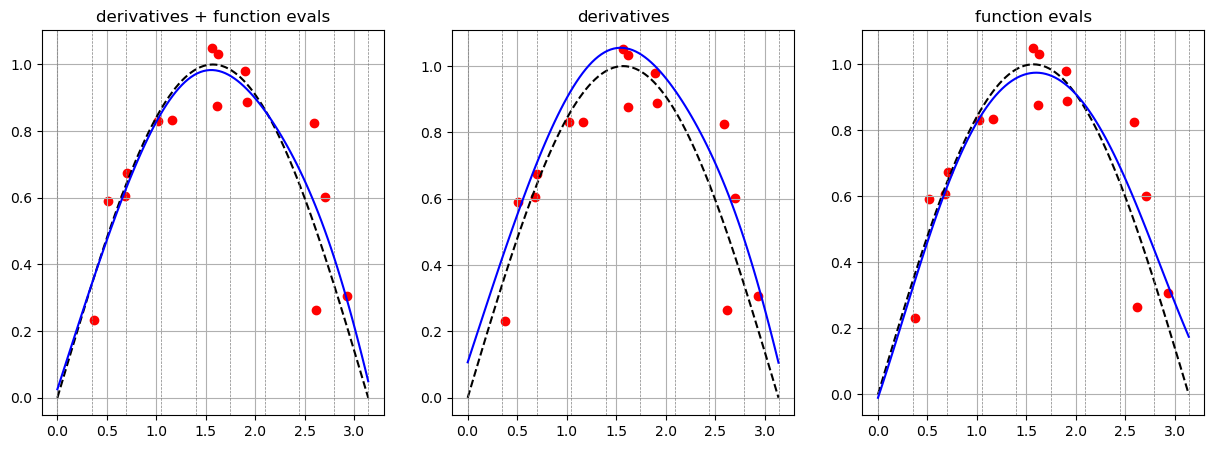

In [122]:
f, ax = plt.subplots(1,3,figsize=(15, 5))
for i in range(3):
    ax[i].plot(grid,func(grid),"k--",label="true")
    ax[i].vlines(referencegrid,0,1,ls="--",colors="grey",lw=0.5,transform=ax[i].get_xaxis_transform(),label="ref grid")
    ax[i].grid()
    ax[i].scatter(datagrid,data_values,c="r")
ax[0].plot(grid,pred_mix,c="b",label="mixed")
ax[1].plot(grid,pred_der,c="b",label="derivatives")
ax[2].plot(grid,pred_val,c="b",label="func_evals")
ax[0].set_title("derivatives + function evals")
ax[1].set_title("derivatives")
ax[2].set_title("function evals")

## Full GPR

In [123]:
bounds = np.array([0.0, np.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 10
datagrid = np.linspace(*bounds,num_reference_points)
data_values = func(datagrid,noise)
derivative_values = grad_func(datagrid,noise)

num_gridpoints = 101
grid = np.linspace(*bounds,num_gridpoints)

In [124]:
K_NN = covMatrix(reference_points=datagrid,data_points=datagrid,length_scale=length_scale)
coeff = solve(K_NN+np.eye(num_datapoints)*noise**2, derivative_values)
var_coeff = solve

prediction = [coeff@dRBF(datagrid,x) for x in grid]
vars = []

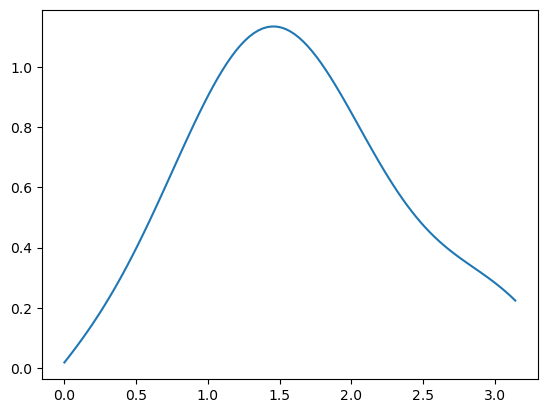

In [125]:
plt.plot(grid,prediction)